# Magic: the Gathering - some ML stuff

Our aim here is to 
1. Analyze how the MTG cards look like
2. Use neural networks to generate random MTG cards.

**Under construction**

The data we use was downloaded from X, and then we used some non-cloud python to wrangle the ~1Gb .json file to something more manageable. We did this by essentially dropping more than half of the card data provided by the original data set.

We first import the standard libraries to do pretty much anything

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The following cell contains the IBM Watson notebook autogenerated code to read Formatted_list.json into a json object named 'card_rext_json' and then creates a pandas DataFrame object called 'cards_df' from it. It will be hidden in the github version; you should uncomment the code in the block after it if you need to use this outside the notebook.

In [44]:
# The code was removed by Watson Studio for sharing.

In [106]:
# Uncomment the following line if you are applying this code outside the original notebook.
# cards_df = pd.read_json(Formatted_list.json)

all_cards_amount = cards_df.shape[0]
print(cards_df.shape)
cards_df.head()

(50454, 17)


,object,id,name,lang,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,set_name,set_type,rarity,flavor_text
0,card,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,en,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,Time Spiral,expansion,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,card,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,en,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,Zendikar,expansion,common,"""We take only what we need to survive. Believe..."
2,card,0000a54c-a511-4925-92dc-01b937f9afad,Spirit,en,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],tmm2,Modern Masters 2015 Tokens,token,common,None
3,card,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,en,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,Ixalan,expansion,common,None
4,card,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,en,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,Revised Edition,core,rare,None


## Data Wrangling and pruning

We'll now start to massage the data set to a more applicable form. Some of our aims are:
1. Remove superfluous columns
2. Remove duplicates.
3. Turn type_line into two columns that contain the card type (creature, enchantment, etc) and then the possible creature type which will be set to None for non-creatures.
4. Create dictionaries for the categorical variables of
    * mana_cost
    * cmc 
    * type_line = (card_type, creature_type?)
    * power
    * toughness
    * colors
    * color_identity
    * set
    * set_type
    * rarity
5. Create functions to go from text to integer array representation (and back) for the text fields of
    * name
    * oracle_text
    * flavor_text
    * creature_type?

### Data Pruning

In [112]:
# Dropping columns that we will not need
# We sort the list by oracle text and flavor text to make sure that when we remove duplicates we prefer to remove a non-textual version.
columns_pruned_df = cards_df.drop(['object', 'lang', 'set_name', 'set_type'], axis = 1).sort_values(by=['oracle_text', 'flavor_text'], ascending=False)

# Removing some bios(?) that are identified by type_line equaling 'Card'
bios_pruned_df  = columns_pruned_df.drop(columns_pruned_df[columns_pruned_df.type_line == 'Card'].index)

# Finally we drop duplicates
cards_pruned_df = bios_pruned_df.drop_duplicates(subset = ['name']).sort_index()

cards_pruned_df.head()

,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe..."


We next process the type_line column into two new columns.

In [121]:
# Running this cell takes some time for unknown reason.

# In the type_line the parts are separated by the following symbol.
type_separator = '—'

# We define a function to parse rows one by one
def type_line_parser(row):
    type_string = row.type_line
    
    # We divide the parsing in two parts depending on if we see the separating symbol.
    if type_separator in type_string: 
        # For creature names we split the type_line on the first instance and then 
        # strip the string from leading or following spaces etc
        card_type, creature_name = [s.strip() for s in type_string.split(type_separator,1)]
        
    else:
        # For non-creature things we just remove leading and following spaces
        # and set the creature type to None.
        card_type = type_string.strip()
        creature_name = None
    
    row['type'] = card_type
    row['creature_type'] = creature_name
    
    return(row)

# Finally we save the new dataframe and drop the old column.
typed_cards_df = cards_pruned_df.apply(type_line_parser, axis = 1).drop(['type_line'], axis=1)

In [122]:
typed_cards_df.head()


,id,name,mana_cost,cmc,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text,type,creature_type
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s...",Creature,Sliver
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe...",Creature,Kor Soldier
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None,Creature,Siren Pirate
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None,Enchantment,Aura
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe...",Creature,Human Knight


In [58]:
# We find those cards that have a non-empty flavor text.
flavor_text_cards = cards_pruned_df.loc[cards_pruned_df.flavor_text.notna()]
flavor_text_cards_amount = flavor_text_cards.shape[0]
print(flavor_text_cards.shape)
flavor_text_cards.head()

(28291, 13)


,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
5,0001f1ef-b957-4a55-b47f-14839cdbab6f,Venerable Knight,{W},1.0,Creature — Human Knight,"When Venerable Knight dies, put a +1/+1 counte...",2,1,[W],[W],eld,uncommon,"""May this blade guide you on your great journe..."
6,00020b05-ecb9-4603-8cc1-8cfa7a14befc,Wildcall,{X}{G}{G},2.0,Sorcery,"Manifest the top card of your library, then pu...",None,None,[G],[G],ugin,rare,A howl on the wind hides many dangers.
9,00042443-4d4e-4087-b4e5-5e781e7cc5fa,Wall of Vipers,{2}{B},3.0,Creature — Snake Wall,Defender (This creature can't attack.)\n{3}: D...,2,4,[B],[B],pcy,uncommon,"What wall can never be climbed, but is always ..."


In [57]:
# We find those cards that have a non-empty oracle text
oracle_text_cards = cards_pruned_df.loc[cards_pruned_df.oracle_text.notna()]
oracle_cards_amount = oracle_text_cards.shape[0]
print(oracle_text_cards.shape)
oracle_text_cards.head()

(49901, 13)


,id,name,mana_cost,cmc,type_line,oracle_text,power,toughness,colors,color_identity,set,rarity,flavor_text
0,0000579f-7b35-4ed3-b44c-db2a538066fe,Fury Sliver,{5}{R},6.0,Creature — Sliver,All Sliver creatures have double strike.,3,3,[R],[R],tsp,uncommon,"""A rift opened, and our arrows were abruptly s..."
1,00006596-1166-4a79-8443-ca9f82e6db4e,Kor Outfitter,{W}{W},2.0,Creature — Kor Soldier,"When Kor Outfitter enters the battlefield, you...",2,2,[W],[W],zen,common,"""We take only what we need to survive. Believe..."
2,0000a54c-a511-4925-92dc-01b937f9afad,Spirit,,0.0,Token Creature — Spirit,Flying,1,1,[W],[W],tmm2,common,None
3,0000cd57-91fe-411f-b798-646e965eec37,Siren Lookout,{2}{U},3.0,Creature — Siren Pirate,Flying\nWhen Siren Lookout enters the battlefi...,1,2,[U],[U],xln,common,None
4,00012bd8-ed68-4978-a22d-f450c8a6e048,Web,{G},1.0,Enchantment — Aura,Enchant creature (Target a creature as you cas...,None,None,[G],[G],3ed,rare,None


<BarContainer object of 17 artists>

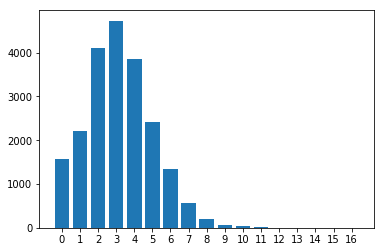

In [100]:

mana_cost_amounts = no_dups_df.cmc.value_counts()

x = range(17)
y = [mana_cost_amounts[j] for j in x]
plt.xticks(range(17))
plt.bar(x,y)

### Dictionary creation



In [128]:
df = typed_cards_df.copy()


categorical_columns = ['mana_cost', 
                       'cmc', 
                       'power', 
                       'toughness', 
                       'colors', 
                       'color_identity', 
                       'set', 
                       'rarity', 
                       'type'
                      ]

df[categorical_columns].dtypes

mana_cost          object
cmc               float64
power              object
toughness          object
colors             object
color_identity     object
set                object
rarity             object
type               object
dtype: object